In [35]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import numpy as np
import folium
import requests

# load the census shape and tract
census_shape = gpd.read_file("shape/lda_000a21a_e/lda_000a21a_e.shp")
census_tract = pd.read_csv("csv/census_ontario_selected_columns.csv")

# Store the ontario stats separately
ontario_stats = census_tract[1:2]

# Filter for Ontario only
census_shape = census_shape[census_shape["PRUID"] == "35"]

# drop PRUID and DGUID as unncessary and convert object to int column
census_shape.drop(columns=["PRUID", "DGUID"], inplace=True)
census_shape["DAUID"] = census_shape["DAUID"].values.astype(int)

# merge the columns together
census_df = pd.merge(
    census_tract, census_shape, left_on="ALT_GEO_CODE", right_on="DAUID", how="inner"
)

# Convert to geodataframe
census_gdf = gpd.GeoDataFrame(census_df, geometry="geometry")

# Convert to WGS84 projection
census_gdf.to_crs("WGS84", inplace=True)

# load the pharmacy data
pharmacy_df = pd.read_csv("csv/Fixed OCP Search.csv")

# Get only active pharmacy
pharmacy_df = pharmacy_df[pharmacy_df["Status"] == "Active"]

# Convert to geodataframe
pharmacy_gpf = gpd.GeoDataFrame(
    pharmacy_df,
    geometry=gpd.points_from_xy(pharmacy_df["Longitude"], pharmacy_df["Latitude"]),
)

# Set reference to standard WGS84
pharmacy_gpf.set_crs("wgs84", allow_override=True, inplace=True)

# load the doctor data
doctor_pf = pd.read_csv("csv/doctors.csv")

# get only the unique clinics that are near here
doctor_pf = doctor_pf.groupby("Postal Code").first()

# Convert to geodataframe
doctor_gpf = gpd.GeoDataFrame(
    doctor_pf,
    geometry=gpd.points_from_xy(doctor_pf["Longitude"], doctor_pf["Latitude"]),
)

# Set reference to standard WGS84
doctor_gpf.set_crs("wgs84", allow_override=True, inplace=True)

# FIlter for locations within the bounding box
doctor_gpf = doctor_gpf[(doctor_gpf.centroid.x > -85) & (doctor_gpf.centroid.x < -77)]
doctor_gpf = doctor_gpf[(doctor_gpf.centroid.y < 45.6) & (doctor_gpf.centroid.y > 40)]

phamracy_gpf = pharmacy_gpf[
    (pharmacy_gpf.centroid.x > -85) & (pharmacy_gpf.centroid.x < -77)
]
pharmacy_gpf = pharmacy_gpf[
    (pharmacy_gpf.centroid.y < 45.6) & (pharmacy_gpf.centroid.y > 40)
]

census_gdf = census_gdf[(census_gdf.centroid.y < 45.6) & (census_gdf.centroid.y > 40)]


sum_col = [
    "Population, 2021",
    "Population, 2016",
    "Total private dwellings",
    "  65 years and over",
    "  Owner",
    "    Bachelor's degree or higher",
    "Population, 2026",
    "0 to 24 years",
    "25 to 64 years",
]

mean_col = [
    "Average household size",
    "Population percentage change, 2016 to 2021",
    "Population density per square kilometre",
    "    Median after-tax income in 2020 among recipients ($)",
    "  Median after-tax income of household in 2020 ($)",
    "Median age of the population",
    "White Collar Percentage",
]


# Helper function to get buffer size around point of interest (POI)
def get_buffer(radius=2000, point=None, buffer_type="radius"):
    if buffer_type == "radius":
        gdf = gpd.GeoDataFrame({"geometry": point}, index=[0])
        # Set the CRS to wgs84 then to EPSG:3347 to create a buffer of 2 km radius
        gdf.set_crs("wgs84", allow_override=True, inplace=True)
        gdf.to_crs("EPSG:3347", inplace=True)

        # Create a buffer of 2 km
        gdf["geometry"] = gdf.buffer(radius)

        # convert back to wgs84
        gdf.to_crs("wgs84", inplace=True)
        return gdf

    else:
        response = requests.post(
            "http://localhost:8080/ors/v2/isochrones/driving-car",
            json={
                "locations": [[point.x, point.y]],
                "range": [900],  # 15 mins
                "range_type": "time",
            },
        )

        # Convert the isocrhone into a polygon
        poly = Polygon(response.json()["features"][0]["geometry"]["coordinates"][0])

        # convert to geodataframe
        gdf = gpd.GeoDataFrame({"geometry": poly}, index=[0])
        gdf.set_crs("wgs84", allow_override=True, inplace=True)
    
        return gdf


def show_southern_ontario_map(
    census_gdf=None, doctor_gpf=None, pharmacy_gpf=None, point_gdf=None
):
    _, ax = plt.subplots(figsize=(16, 24))

    census_gdf.plot(ax=ax, color="blue")
    doctor_gpf.plot(ax=ax, color="red")
    pharmacy_gpf.plot(ax=ax, color="green")
    point_gdf.plot(ax=ax, color="yellow")

    plt.show()


def show_map(
    census_within_home=None,
    doctor_within_home=None,
    buffer_gdf=None,
    phamracy_within_home=None,
):
    _, ax = plt.subplots(figsize=(16, 16))

    buffer_gdf.plot(ax=ax, color="gray")
    try:
        census_within_home.plot(ax=ax, color="blue")
    except:
        pass

    try:
        doctor_within_home.plot(ax=ax, color="red")
    except:
        pass

    try:
        pharmacy_within_home.plot(ax=ax, color="green")
    except:
        pass

    plt.show()


def show_folium_map(
    census_within_home=None,
    doctor_within_home=None,
    point=None,
    phamracy_within_home=None,
    buffer_gdf=None,
):
    m = census_within_home.explore(name="census")
    m = buffer_gdf.explore(m=m, color="gray", name="Buffer")
    m = pharmacy_within_home.explore(m=m, color="green", name="Pharmacy")
    m = doctor_within_home.explore(m=m, color="red", name="Doctors")
    point_geo = gdf = gpd.GeoDataFrame({"geometry": point}, index=[0])
    m = point_geo.explore(m=m, color="yellow", name="Point")
    return m


C:\Users\shann\AppData\Local\Temp\ipykernel_16584\3460106441.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  doctor_gpf = doctor_gpf[(doctor_gpf.centroid.x > -85) & (doctor_gpf.centroid.x < -77)]
C:\Users\shann\AppData\Local\Temp\ipykernel_16584\3460106441.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  doctor_gpf = doctor_gpf[(doctor_gpf.centroid.y < 45.6) & (doctor_gpf.centroid.y > 40)]
C:\Users\shann\AppData\Local\Temp\ipykernel_16584\3460106441.py:69: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (pharmacy_gpf.centroid.x > -85) & (pharmacy_gpf.centroid.x < 

In [37]:
cumulative_stats = pd.DataFrame()

for iter, row in pharmacy_gpf.iterrows():
    point = row['geometry'] 
    buffer_gdf = get_buffer(point=point)

    predicate = 'intersects'

    census_within_buffer = gpd.sjoin(census_gdf, buffer_gdf, how='inner', predicate=predicate)
    pharmacy_within_buffer = gpd.sjoin(pharmacy_gpf, buffer_gdf, how='inner', predicate=predicate)
    doctor_within_buffer = gpd.sjoin(doctor_gpf, buffer_gdf, how='inner', predicate=predicate)
    num_of_docs = doctor_within_buffer['City'].count()
    num_of_pharmacies = pharmacy_within_buffer['City'].count()


    stats_within_radius = pd.DataFrame()

    for col in sum_col:
        stats_within_radius.loc[0, col] = int(census_within_buffer[col].sum())

    for col in mean_col:
        stats_within_radius.loc[0, col] = round(census_within_buffer[col].mean(), 1)


    stats_within_radius['num of pharmacies'] = num_of_pharmacies
    stats_within_radius['num of doctors'] = num_of_docs
    cumulative_stats = pd.concat([cumulative_stats, stats_within_radius])
    
quantitle_stats = cumulative_stats.quantile([0.25, 0.5, 0.75, 0.9])
quantitle_stats.to_csv("quantitle_stats.csv")

In [80]:
point = Point(-79.65782811548277, 43.77000457918012) 
buffer_gdf = get_buffer(point=point)

predicate = 'intersects'

census_within_home = gpd.sjoin(census_gdf, buffer_gdf, how='inner', predicate=predicate)
pharmacy_within_home = gpd.sjoin(pharmacy_gpf, buffer_gdf, how='inner', predicate=predicate)
doctor_within_home = gpd.sjoin(doctor_gpf, buffer_gdf, how='inner', predicate=predicate)
num_of_docs = doctor_within_home['City'].count()
num_of_pharmacies = pharmacy_within_home['City'].count()


summary_stats_within_radius = pd.DataFrame()

for col in sum_col:
    summary_stats_within_radius.loc[0, col] = int(census_within_home[col].sum())

for col in mean_col:
    summary_stats_within_radius.loc[0, col] = round(census_within_home[col].mean(), 1)


summary_stats_within_radius['num of pharmacies'] = num_of_pharmacies
summary_stats_within_radius['num of doctors'] = num_of_docs

show_folium_map(census_within_home=census_within_home, doctor_within_home=doctor_within_home, point=point, phamracy_within_home=pharmacy_within_home, buffer_gdf=buffer_gdf)

<Axes: >

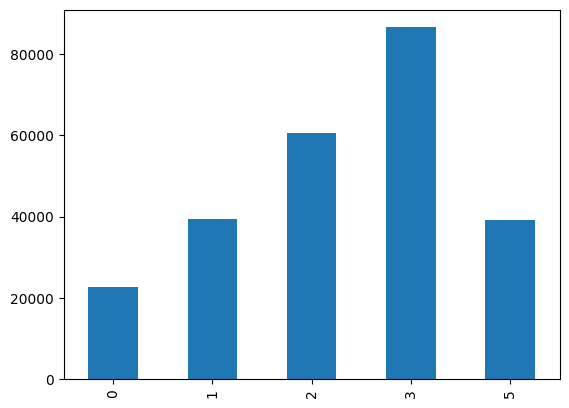

In [94]:
combined_df = pd.concat([quantitle_stats, ontario_stats, summary_stats_within_radius], axis=0, ignore_index=True)
combined_df['Population, 2021'][[0, 1, 2, 3 ,5]].plot.bar()

In [236]:
road_gdf = gpd.read_file('shape/lrnf000r23a_e/lrnf000r23a_e.shp')
road_gdf = road_gdf[road_gdf['PRUID_R'] == '35']
road_gdf = road_gdf[road_gdf['CLASS'] != '23']
road_gdf.distance(home_gdf)